<a href="https://colab.research.google.com/github/akrampathan07/Deep-Learning-Project/blob/main/Airline_Delay_Prediction(ML%20Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score, classification_report,
    f1_score,  confusion_matrix,
    roc_curve, PrecisionRecallDisplay, roc_auc_score,
    precision_recall_curve, RocCurveDisplay
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
replace DelayedFlights.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DelayedFlights.csv      
replace st99_d00.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: st99_d00.dbf            
replace st99_d00.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: st99_d00.shp            
replace st99_d00.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: st99_d00.shx            
replace code_airport_type.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: code_airport_type.csv   
replace dest_avg_time.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dest_avg_time.csv       
replace origin_avg_time.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: origin_avg_time.csv     
replace tailnum_avg_time.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tailnum_avg_time.csv    


In [ ]:
df = pd.read_csv("/content/DelayedFlights.csv")

# 1.1 Drop first column and observe dimensions
df = df.drop(["Unnamed: 0"], axis=1)

print('Dataframe dimensions:', df.shape)

df_flights = df.copy()
df.head()

Dataframe dimensions: (1936758, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null value (count)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]).T.rename(index={0:'null values (%)'}))
tab_info = tab_info.append(pd.DataFrame(df.describe().astype(int)))

tab_info = tab_info.T

tab_info

,column type,null value (count),null values (%),count,mean,std,min,25%,50%,75%,max
Year,int64,0,0.0,1936758,2008,0,2008,2008,2008,2008,2008
Month,int64,0,0.0,1936758,6,3,1,3,6,9,12
DayofMonth,int64,0,0.0,1936758,15,8,1,8,16,23,31
DayOfWeek,int64,0,0.0,1936758,3,1,1,2,4,6,7
DepTime,float64,0,0.0,1936758,1518,450,1,1203,1545,1900,2400
CRSDepTime,int64,0,0.0,1936758,1467,424,0,1135,1510,1815,2359
ArrTime,float64,7110,0.003671,1929648,1610,548,1,1316,1715,2030,2400
CRSArrTime,int64,0,0.0,1936758,1634,464,0,1325,1705,2014,2400
UniqueCarrier,object,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FlightNum,int64,0,0.0,1936758,2184,1944,1,610,1543,3422,9742


In [ ]:
date_list = ['Year','Month','DayofMonth','DayOfWeek']
delay_time_list = ['DepTime','DepDelay','ArrTime','ArrDelay	']
delay_reason_list = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
flight_info_list = ['FlightNum','Origin','Dest']

**Observations:**

Only when Arrival Delay is longer than 15 minutes there's data about what caused the delay.
Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay.

In cases of cancelation or diversion there's no data related to delay causes.

Thus these columns can be imputed with 0.

**2.EDA**

2.1 Label




In [ ]:
# Add new date and delay variables
df['FlightDate'] = pd.to_datetime(df['Year'].astype(str) + '/' + df['Month'].astype(str) + '/' + df['DayofMonth'].astype(str))

# counted as delay if > 15 min
df['DepDel15'] = np.where(df['DepDelay'] > 15,1,0)
df['ArrDel15'] = np.where(df['ArrDelay'] > 15,1,0)

array([[<Axes: title={'center': 'DepDel15'}>]], dtype=object)

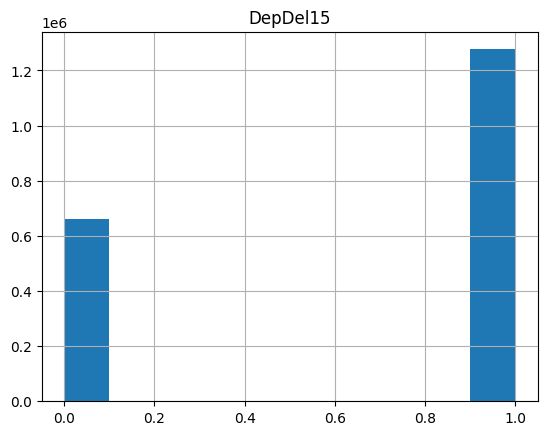

In [ ]:
df.hist(column='DepDel15')

Since we are predicting delays, using a threshold of 15 minutes to categorize a delay leads to the delays being the majority class. In view of this, we will experiment with another threshold for delays while at the same time predicting severe delays.

In [ ]:
df['DepDel30'] = np.where(df['DepDelay'] > 30,1,0)
df['DepDel30'].value_counts()

0    1122307
1     814451
Name: DepDel30, dtype: int64

Using a threshold of 30 minutes leads to the delays being the minority class and at the same time prediting longer delays might have a deeper business application.

array([[<Axes: title={'center': 'DepDel30'}>]], dtype=object)

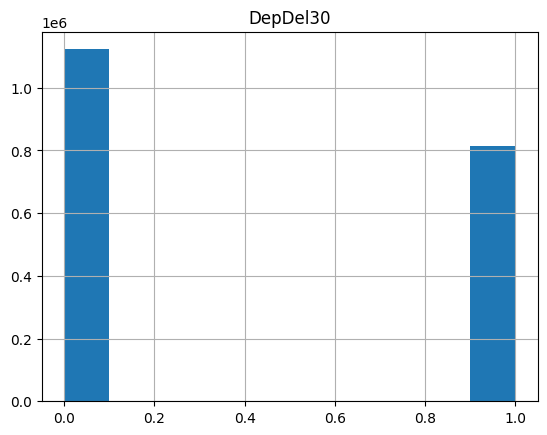

In [ ]:
df.hist(column='DepDel30')

**2.2 Exploring Arr and Dep Delay**

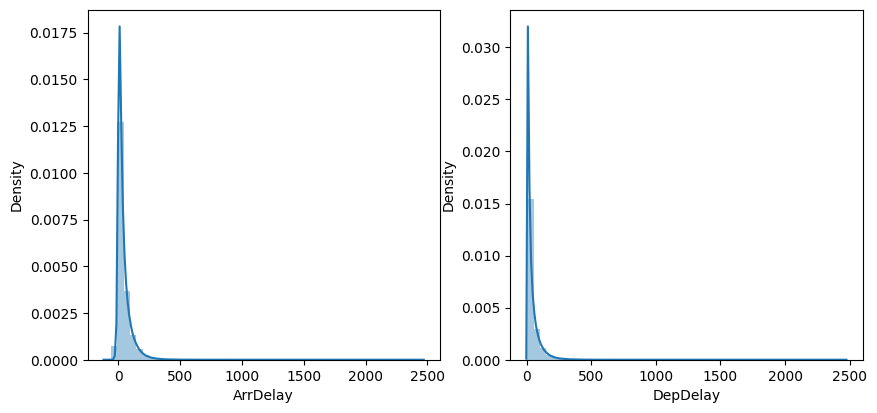

In [ ]:
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
sns.distplot(df['ArrDelay'])

plt.subplot(2,2,2)
sns.distplot(df['DepDelay'])

plt.show()

Delays are mostly located on the left side of the graph, with a long tail to the right. The majority of delays are short, and the longer delays, while unusual, are more heavy loaded in time.

**2.3 Group DepDelay by TailNum**

,count,min,max,mean,std,sum
TailNum,,,,,,
N325SW,965.0,6.0,346.0,33.818653,40.394081,32635.0
N676SW,951.0,6.0,404.0,32.865405,38.751961,31255.0
N658SW,945.0,6.0,523.0,37.916402,44.243936,35831.0
N313SW,937.0,6.0,343.0,36.005336,43.184198,33737.0
N308SA,936.0,6.0,286.0,32.824786,38.785648,30724.0
...,...,...,...,...,...,...
N826MH,1.0,12.0,12.0,12.000000,NaN,12.0
N74007,1.0,9.0,9.0,9.000000,NaN,9.0
N76010,1.0,16.0,16.0,16.000000,NaN,16.0


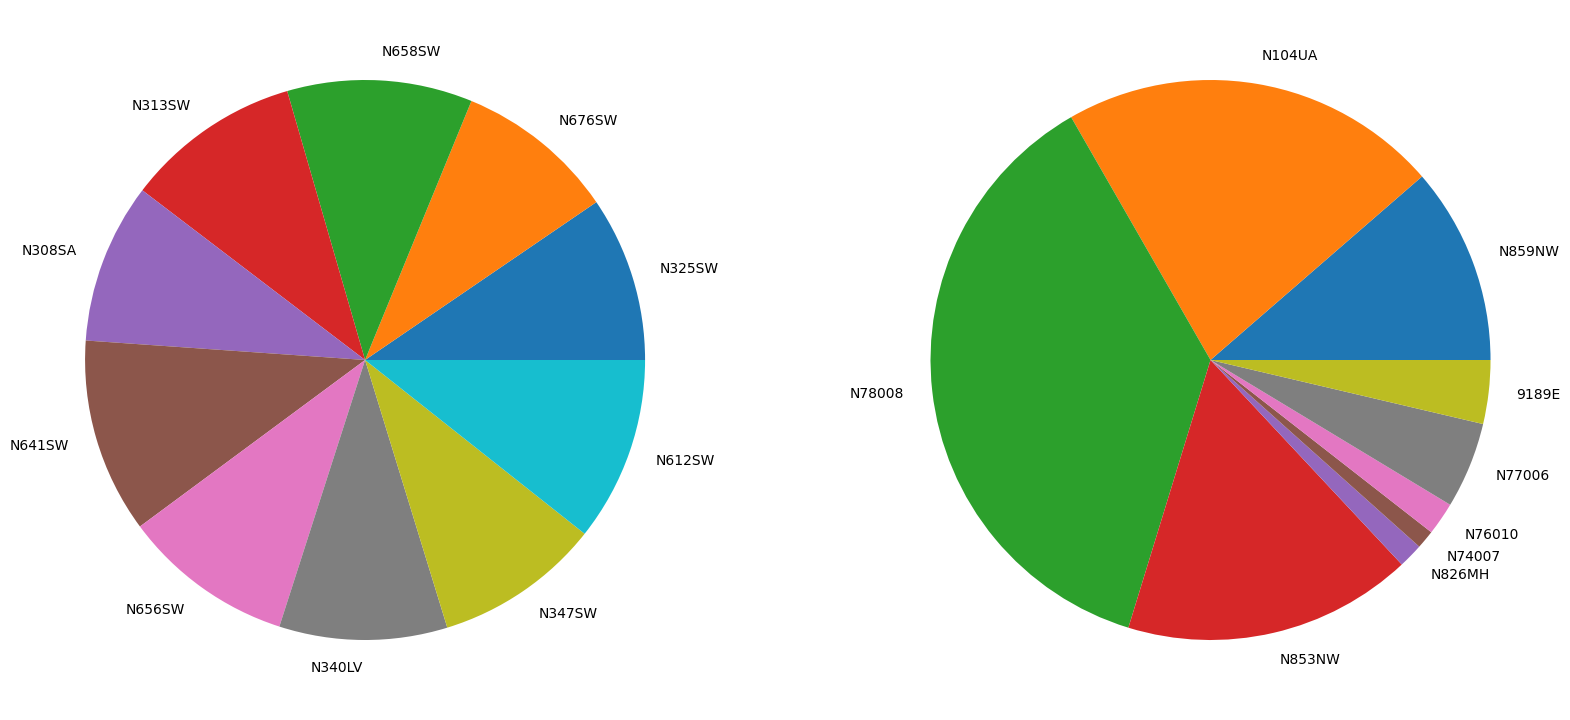

In [ ]:
def get_stats(group):
    return {'count': group.count(), 'min': group.min(), 'max': group.max(), 'mean': group.mean(), 'std': group.std(), 'sum': group.sum()}

tailnum_stats = df['DepDelay'].groupby(df['TailNum']).apply(get_stats).unstack().sort_values('count', ascending = False)

plt.figure(figsize = (20,20))

plt.subplot(2,2,1)
plt.pie(tailnum_stats['mean'][:10], labels = tailnum_stats.index[:10])

plt.subplot(2,2,2)
plt.pie(tailnum_stats['mean'][-9:], labels = tailnum_stats.index[-9:])

tailnum_stats

Popular aircrafts on average have a consistent delay of approximaltely 30 min while less popular aircrafts have a fluctuating delay time

**2.4 Dest groupby DepDelay**

In [ ]:
dest_stats = df['DepDel15'].groupby(df['Dest']).apply(get_stats).unstack().sort_values('count', ascending = False)
dest_stats.sort_values(['count','mean'], ascending = False)

,count,min,max,mean,std,sum
Dest,,,,,,
ORD,108984.0,0.0,1.0,0.753468,0.430994,82116.0
ATL,106898.0,0.0,1.0,0.659432,0.473902,70492.0
DFW,70657.0,0.0,1.0,0.661647,0.473153,46750.0
DEN,63003.0,0.0,1.0,0.621399,0.485042,39150.0
LAX,59969.0,0.0,1.0,0.609231,0.487927,36535.0
...,...,...,...,...,...,...
INL,9.0,1.0,1.0,1.000000,0.000000,9.0
PIR,3.0,1.0,1.0,1.000000,0.000000,3.0
CYS,1.0,0.0,0.0,0.000000,NaN,0.0


Popular destinations are more likely to get delay perhaps due to traffic congestion

**2.5 Frequency of Originating and Departing Airports**

Viewing top 20 Originating and Departing Airports

<Axes: xlabel='Dest', ylabel='count'>

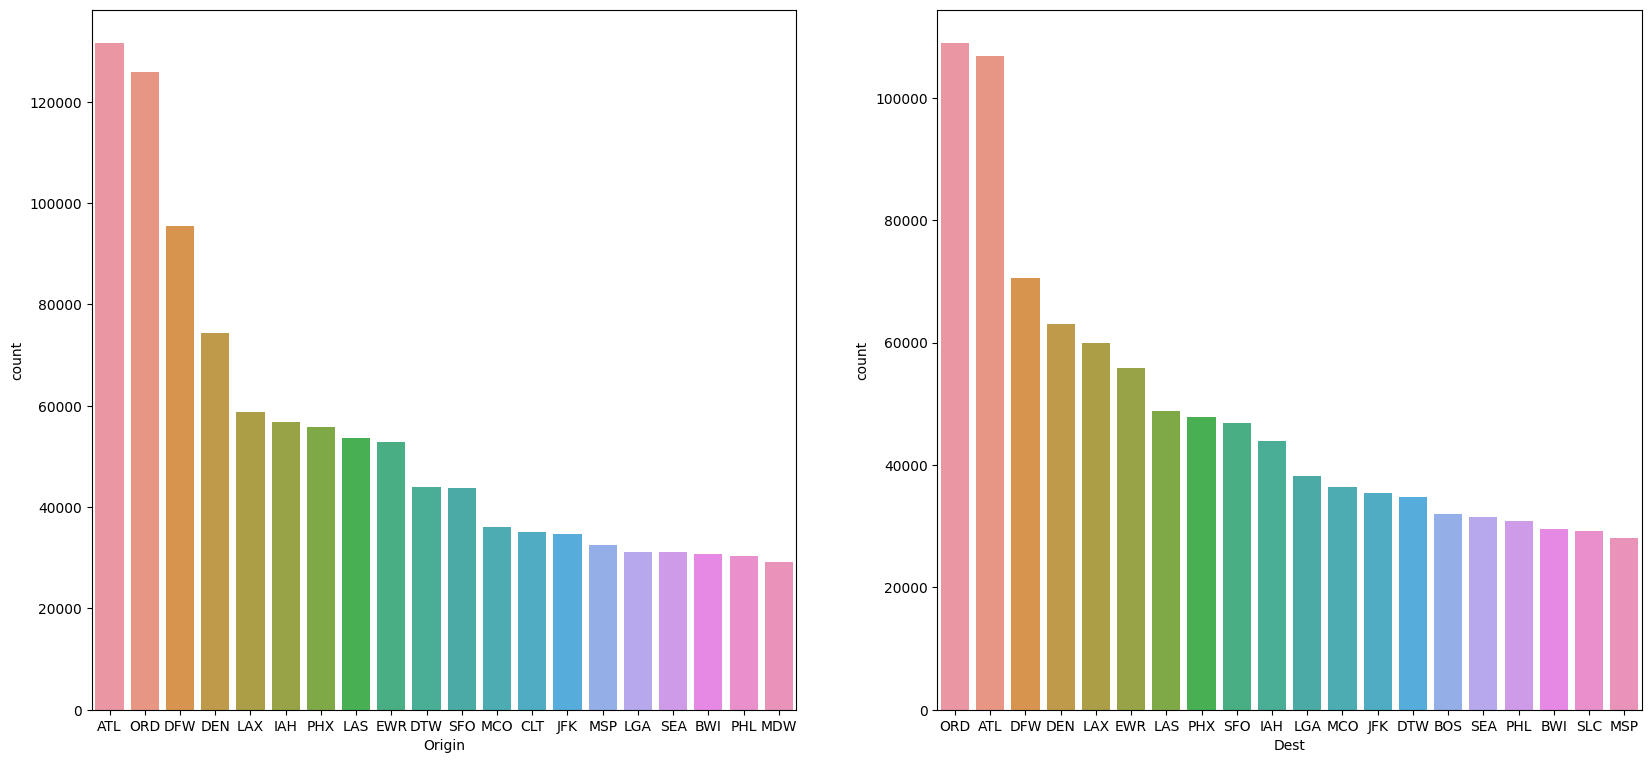

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(2,2,1)
sns.countplot(x='Origin', data=df, order=df['Origin'].value_counts().iloc[:20].index)

plt.subplot(2,2,2)
sns.countplot(x='Dest', data=df, order=df['Dest'].value_counts().iloc[:20].index)

A majority of flights are occuring between ATL, ORD, DFW, DEN, and LAX.

**2.6 Seasonal Effect**

Month and DayOfWeek

<Axes: xlabel='DayOfWeek', ylabel='count'>

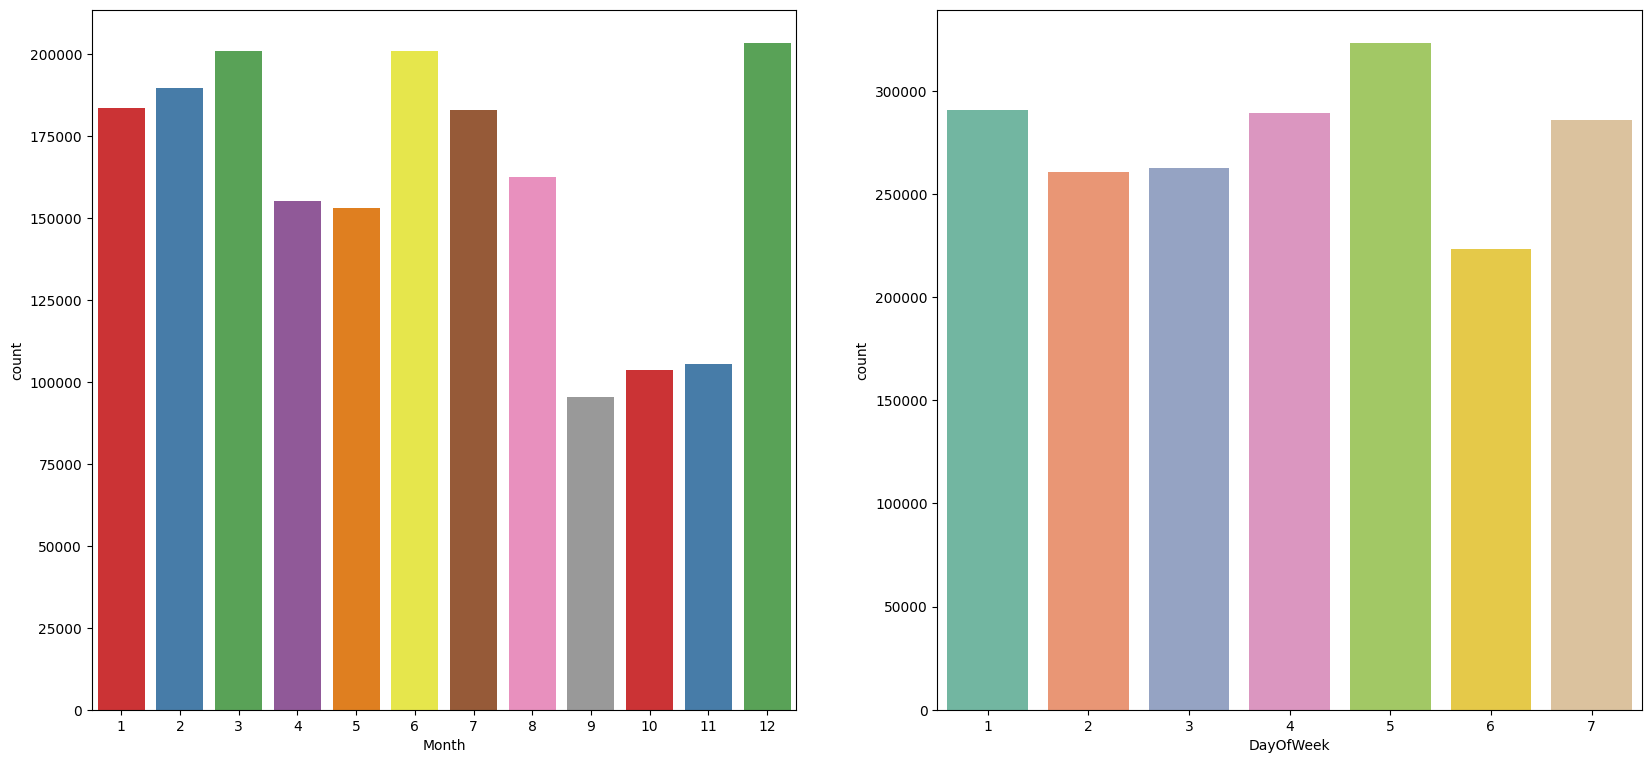

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(2,2,1)
sns.countplot(x = 'Month', palette='Set1', data = df)

plt.subplot(2,2,2)
sns.countplot(x = 'DayOfWeek', palette='Set2', data = df)

Month effect:

There is more data for the months of January and December 2008. This can be expected as travelling is popular during the end of the year. The summer months also see an uptick in flights data.

Week effect:

It seems that there are most fligths on Friday (5) according to our datset.

**2.7 Cancelled and Diverted Flights**

In [ ]:
df["Cancelled"].value_counts()

0    1936125
1        633
Name: Cancelled, dtype: int64

There were only a tiny fraction of flights that were cancelled.

In [ ]:
df["Diverted"].value_counts()

0    1929004
1       7754
Name: Diverted, dtype: int64

A small proportion of flights were diverted.

**2.8 Bottom 20 origin and dest airports**

In [ ]:
bottom_20_origin = df['Origin'].value_counts()[-20:]
bottom_20_origin

TEX    52
LWB    48
GST    40
CMX    34
RFD    33
RHI    33
ALO    31
ACY    29
ITH    29
BPT    27
SUX    22
PLN    21
WYS    10
HTS    10
BLI     4
BJI     4
PIR     3
PUB     2
INL     1
TUP     1
Name: Origin, dtype: int64

In [ ]:
bottom_20_dest = df['Dest'].value_counts()[-20:]
bottom_20_dest

YKM    47
GST    46
RHI    45
DLG    43
AKN    43
ACY    38
LWB    35
HTS    33
TEX    32
ADK    31
WYS    31
SUX    28
ITH    16
BLI    13
BJI    12
INL     9
PIR     3
CYS     1
TUP     1
OGD     1
Name: Dest, dtype: int64

There are some airports that are highly infrequently used.

Origin Airport Binning Exploration

In [ ]:
origin = df['Origin'].value_counts()
origin.quantile([.25, .5, .75])

0.25     262.0
0.50     905.0
0.75    3652.0
Name: Origin, dtype: float64

**2.9 Carriers**

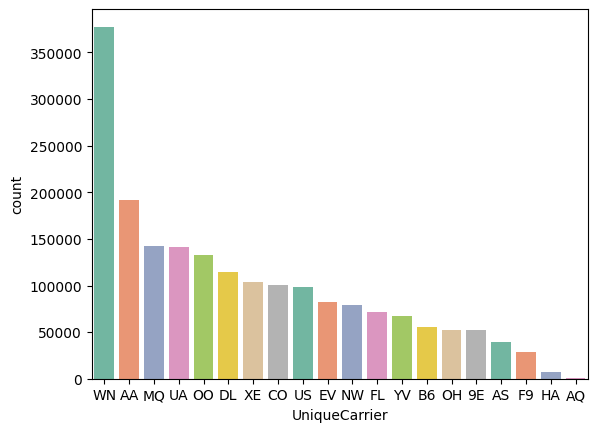

WN    377602
AA    191865
MQ    141920
UA    141426
OO    132433
DL    114238
XE    103663
CO    100195
US     98425
EV     81877
NW     79108
FL     71284
YV     67063
B6     55315
OH     52657
9E     51885
AS     39293
F9     28269
HA      7490
AQ       750
Name: UniqueCarrier, dtype: int64

In [ ]:
sns.countplot(x='UniqueCarrier', palette='Set2', data=df, order=df['UniqueCarrier'].value_counts().index)
plt.show()

df['UniqueCarrier'].value_counts()

Despite there being only 20 unique carriers, WN is the most popular by a large margin of approximately 2X the next carrier (AA). As the carrier column is categorical without an ordinal ranking, it can be binned based on the 'popularity' of an airline which gives an ordinal ranking.

In [ ]:
def label_carrier(carrier):
    if carrier == 'WN':
        return 'highly_popular'  # Highly Popular (> 200,000 occurences)
    if carrier in ['AA', 'MQ', 'UA', 'OO', 'DL', 'XE', 'CO']:
        return 'popular'  # Popular (100,000 - 200,000 occurences)
    if carrier in ['US', 'EV', 'NW', 'FL', 'YV', 'B6', 'OH', '9E', 'AS', 'F9', 'HA', 'AQ']:
        return 'unpopular'  # Unpopular

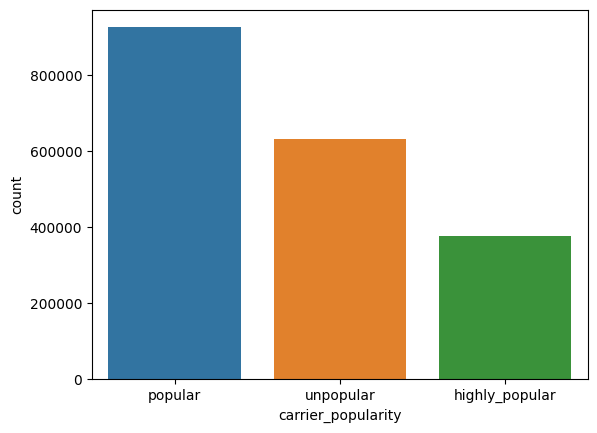

In [ ]:
df['carrier_popularity'] = df['UniqueCarrier'].apply(lambda x: label_carrier(x))
sns.countplot(x='carrier_popularity', data=df, order=df['carrier_popularity'].value_counts().index)
plt.show()

There are approximately 2X more unpopular carriers over the most popular carrier, WN.

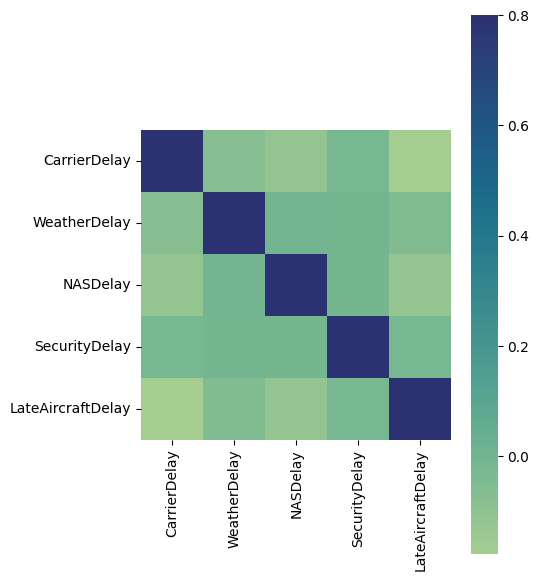

In [ ]:
corrmat = df[delay_reason_list].corr()
f, ax = plt.subplots(figsize=(5,7))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="crest");
plt.show()

The chart above shows a weak correlation.

**3. PreProcessing**

Since we are trying to predict if a flight will be delayed before its departure, we consider features that are only available before departure.

Features not used and why:

Year: because the dataset is made up completely from 2008.

DepTime: actual departure time is unknown before flight boarding.

ArrTime: actual arrival time at dest is unknown before flight boarding.

ActualElapsedTime: unknown before flight boarding.

AirTime: unknown before flight landing.

DepDelay: used for target column.

ArrDelay: unknown before flight landing.

TaxiOut: unknown before flight boarding.

Cancelled: unknown before flight check-in, also insignificant data.

CancellationCode: same as Cancelled.

Diverted: unknown before flight takeoff.

In [ ]:
days_in_month = {
    1: 31,
    2: 29,
    3: 31,
    4: 30,
    5: 30,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31,
}

The status quo of 15 minutes as the acceptable on-time performance to classify a flight as ‘late’ is widely accepted in the field currently. We aim to identify flights that will cause great distress to all parties involved, thus we have set a threshold of 30 minutes to determine if a flight is delayed.

**3.1 Train Test Split**

In [ ]:
df_flights['DepDel30'] = np.where(df_flights['DepDelay'] > 30, 1, 0)

pre_depart_features = [
    'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier',
    'FlightNum', 'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'Distance',
    'TaxiIn', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
    'LateAircraftDelay'
]

# Drop nulls
df_flights.dropna(subset=['TailNum', 'CRSElapsedTime'], inplace=True)
df_flights = df_flights[df_flights['TailNum'] != 'Unknow']  # Incorrect row

X = df_flights[pre_depart_features]
y = df_flights['DepDel30']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1355586, 18)
(1355586,)


In [ ]:
y_train.value_counts()

0    785547
1    570039
Name: DepDel30, dtype: int64

Label = 1 is categorised as a delayed flight with an actual departure time of 30 minutes greater than the scheduled departure time. From the training data, it can be observed that there are more 'not delayed' flights. There is no drastic class imbalance present, albeit some. Thus we will consider using the 'balanced' hyperparameter for model training.

**3.2 Train dataset exploration**
for quantile thresholds for binning

**3.2.1 Carrier by popularity**
This feature will be hardcoded based on the quantile information by counts in the training dataset.

In [ ]:
X_train_temp = X_train.copy()

In [ ]:
X_train_temp['UniqueCarrier'].value_counts()

WN    264867
AA    134275
MQ     99329
UA     98769
OO     92647
DL     79932
XE     72717
CO     69831
US     68934
EV     57344
NW     55385
FL     49879
YV     47164
B6     38682
OH     36794
9E     36181
AS     27353
F9     19677
HA      5294
AQ       532
Name: UniqueCarrier, dtype: int64

In [ ]:
X_train_temp['UniqueCarrier'].value_counts().quantile([.25, .5, .75], interpolation='nearest')

0.25    36794
0.50    57344
0.75    79932
Name: UniqueCarrier, dtype: int64

In [ ]:
def label_carrier_train(carrier):
    if carrier in ['WN', 'AA', 'MQ', 'UA', 'OO']:
        return 'popular'
    if carrier in ['DL', 'XE', 'CO', 'US', 'EV', 'NW', 'FL', 'YV', 'B6']:
        return 'average'
    if carrier in ['OH', '9E', 'AS', 'F9', 'HA', 'AQ']:
        return 'unpopular'

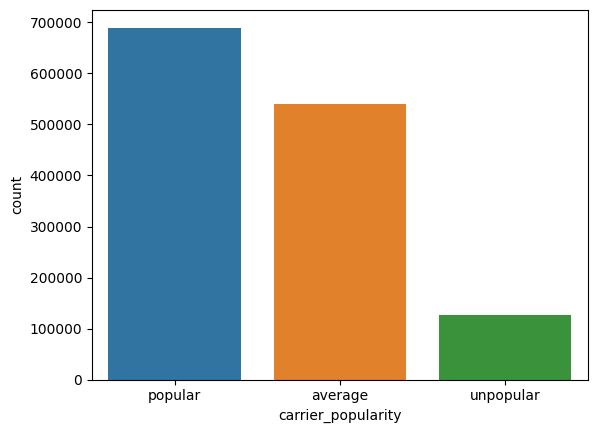

In [ ]:
X_train_temp['carrier_popularity'] = X_train_temp['UniqueCarrier'].apply(lambda x: label_carrier_train(x))
sns.countplot(x='carrier_popularity', data=X_train_temp, order=X_train_temp['carrier_popularity'].value_counts().index)
plt.show()

We are able to capture the trends of the carriers' usages

**3.2.2 Origin, Dest**
Create airport type column based on iata_code of airport. This new column will be one-hot encoded

In [ ]:
def bin_airport(df, left_col='Origin'):
    df = df.copy()
    codes_airports_types = pd.read_csv('/content/code_airport_type.csv', index_col='iata_code')

    df = df.merge(codes_airports_types, left_on=left_col, right_on='iata_code', how='left')
    df.rename({'type': left_col+'_airport_type'}, axis=1, inplace=True)

    return df

Using the mean departure delay minutes for the originating airport, a mean arrival delay for the destination airport and hardcoding these values may lead to more intricate aspects of the data.

In [ ]:
train_idx = X_train.index
df_train_idx = df[df.index.isin(train_idx)]
df_train_idx.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FlightDate,DepDel15,ArrDel15,DepDel30,carrier_popularity
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-01-03,0,0,0,highly_popular
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-01-03,1,0,0,highly_popular
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-01-03,0,0,0,highly_popular
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0,2008-01-03,1,1,1,highly_popular
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN,2008-01-03,1,0,0,highly_popular


In [ ]:
origin_avg_time = df_train_idx.groupby('Origin')['DepDelay'].mean().rename('origin_mean_DepDelay')
origin_avg_time.to_csv('/content/origin_avg_time.csv')

In [ ]:
origin_avg_time = pd.read_csv('/content/origin_avg_time.csv')
origin_avg_time

,Origin,origin_mean_DepDelay
0,ABE,60.398256
1,ABI,68.381625
2,ABQ,36.716700
3,ABY,47.769634
4,ACK,58.527559
...,...,...
298,WYS,23.000000
299,XNA,54.783912
300,YAK,58.927152
301,YKM,20.200000


In [ ]:
dest_avg_time = df_train_idx.groupby('Dest')['ArrDelay'].mean().rename('dest_mean_ArrDelay')
dest_avg_time.to_csv('/content/dest_avg_time.csv')

In [ ]:
dest_avg_time = pd.read_csv('/content/dest_avg_time.csv')
dest_avg_time

,Dest,dest_mean_ArrDelay
0,ABE,48.322757
1,ABI,35.440594
2,ABQ,32.298109
3,ABY,48.792208
4,ACK,55.027778
...,...,...
299,WYS,20.882353
300,XNA,47.155003
301,YAK,52.357143
302,YKM,26.918919


**3.2.3 Tail Number**

A particular plane identified by its TailNum could have an effect on the Delay. Thus, we deem this feature to be useful for the model. However, it has a high number of categories and thus is highly cardinal.

Quantile binning and One-Hot Encoding will not work for this column. Thus we will try to hardcode the mean delay on the training dataset.

In [ ]:
X_train_temp['TailNum'].value_counts()

N325SW    696
N676SW    688
N313SW    664
N641SW    663
N658SW    659
         ... 
N78008      1
N702DN      1
N194UA      1
N809NW      1
N76010      1
Name: TailNum, Length: 5357, dtype: int64

In [ ]:
tailnum_avg_time = df_train_idx.groupby('TailNum')['DepDelay'].mean().rename('tailnum_mean_DepDelay')
tailnum_avg_time.to_csv('/content/tailnum_avg_time.csv')

In [ ]:
tailnum_avg_time = pd.read_csv('/content/tailnum_avg_time.csv')
tailnum_avg_time

,TailNum,tailnum_mean_DepDelay
0,80009E,46.865169
1,80019E,39.776000
2,80059E,47.345588
3,80129E,44.793706
4,80139E,40.234201
...,...,...
5352,N998AT,44.783290
5353,N998DL,38.442231
5354,N999CA,57.754717
5355,N999DN,45.661922


In [ ]:
def add_mean_column(df, file_path, col_name):
    avg_time_df = pd.read_csv(file_path)
    df = df.merge(avg_time_df, on=col_name, how='left')
    return df

**3.3 Feature Engineering**

In [ ]:
def split_hour(num_t):
    # this time is given as hhmm, thus for any length lesser than 3 digits,
    # we will assume it is during the midnight hour
    s_time = str(num_t)
    if len(s_time) > 2:
        s_min = s_time[-2:]
        s_hour = s_time.replace(s_min, '')
        if s_hour == '':
            s_hour = s_min
    else:
        s_hour = s_time
    return float(s_hour)

def split_min(num_t):
    s_time = str(num_t)
    s_min = s_time[-2:]
    return float(s_min)


def process_features(df):
    df = df.copy()
    # Split time columns into hour and minute
    df['CRSDepHour'] = df['CRSDepTime'].apply(lambda x: split_hour(x))
    df['CRSDepMin'] = df['CRSDepTime'].apply(lambda x: split_min(x))

    df['CRSArrHour'] = df['CRSArrTime'].apply(lambda x: split_hour(x))
    df['CRSArrMin'] = df['CRSArrTime'].apply(lambda x: split_min(x))

    # Drop time columns
    df.drop(['CRSDepTime', 'CRSArrTime'], axis=1, inplace=True)

    # Transform days, time in sin & cos
    df['days_in_month'] = df['Month'].map(days_in_month)

    df['Month_sin'] = np.sin(df['Month'] * (2 * np.pi / 12))
    df['Month_cos'] = np.cos(df['Month'] * (2 * np.pi / 12))

    df['DayofMonth_sin'] = np.sin(df['DayofMonth'] * (2 * np.pi / df['days_in_month']))
    df['DayofMonth_cos'] = np.cos(df['DayofMonth'] * (2 * np.pi / df['days_in_month']))

    df['DayOfWeek_sin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
    df['DayOfWeek_cos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))

    df['CRSDepHour_sin'] = np.sin(df['CRSDepHour'] * (2 * np.pi / 24))
    df['CRSDepHour_cos'] = np.cos(df['CRSDepHour'] * (2 * np.pi / 24))

    df['CRSDepMin_sin'] = np.sin(df['CRSDepMin'] * (2 * np.pi / 60))
    df['CRSDepMin_cos'] = np.cos(df['CRSDepMin'] * (2 * np.pi / 60))

    df['CRSArrHour_sin'] = np.sin(df['CRSArrHour'] * (2 * np.pi / 24))
    df['CRSArrHour_cos'] = np.cos(df['CRSArrHour'] * (2 * np.pi / 24))

    df['CRSArrMin_sin'] = np.sin(df['CRSArrMin'] * (2 * np.pi / 60))
    df['CRSArrMin_cos'] = np.cos(df['CRSArrMin'] * (2 * np.pi / 60))

    # Create is_weekend col
    df['is_weekend'] = df['DayOfWeek'].isin([1, 7]).astype(int)

    # Drop day and time columns
    df.drop(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepHour', 'CRSDepMin', 'CRSArrHour', 'CRSArrMin', 'days_in_month'], axis=1, inplace=True)

    # Log Distance column as there is a high std dev
    df['log_Distance'] = np.log(df['Distance'])

    # Bin and OHE Carriers
    df['carrier_popularity'] = df['UniqueCarrier'].apply(lambda x: label_carrier_train(x))
    df = pd.get_dummies(df, prefix=['carrier'], columns=['carrier_popularity'])

    # Bin and OHE Origin Airport
    df = bin_airport(df)
    df = pd.get_dummies(df, prefix=['Origin'], columns=['Origin_airport_type'])

        # Bin and OHE Dest Airport
    df = bin_airport(df, left_col='Dest')
    df = pd.get_dummies(df, prefix=['Dest'], columns=['Dest_airport_type'])

    # Get avg delay
    df = add_mean_column(df, '/content/origin_avg_time.csv', 'Origin')
    df = add_mean_column(df, '/content/dest_avg_time.csv', 'Dest')
    df = add_mean_column(df, '/content/tailnum_avg_time.csv', 'TailNum')

    # Drop original columns
    df.drop(['Distance', 'UniqueCarrier', 'Origin', 'Dest', 'TailNum'], axis=1, inplace=True)  #, 'TailNum'

    # Impute nulls with 0
    for col in ['TaxiIn', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'dest_mean_ArrDelay', 'tailnum_mean_DepDelay']:
        df[col] = df[col].fillna(0)

    return df

X_pr = process_features(X_train.copy())
X_pr.head(5)

,FlightNum,CRSElapsedTime,TaxiIn,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month_sin,Month_cos,DayofMonth_sin,DayofMonth_cos,DayOfWeek_sin,DayOfWeek_cos,CRSDepHour_sin,CRSDepHour_cos,CRSDepMin_sin,CRSDepMin_cos,CRSArrHour_sin,CRSArrHour_cos,CRSArrMin_sin,CRSArrMin_cos,is_weekend,log_Distance,carrier_average,carrier_popular,carrier_unpopular,Origin_large_airport,Origin_medium_airport,Origin_small_airport,Dest_large_airport,Dest_medium_airport,Dest_small_airport,origin_mean_DepDelay,dest_mean_ArrDelay,tailnum_mean_DepDelay
0,1127,127.0,8.0,0.0,0.0,0.0,0.0,0.0,-8.660254e-01,0.500000,-0.848644,0.528964,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,-0.309017,0.951057,0.866025,-5.000000e-01,4.067366e-01,9.135455e-01,1,6.432940,0,1,0,1,0,0,1,0,0,39.000372,59.869328,56.026786
1,1046,114.0,4.0,30.0,0.0,0.0,0.0,0.0,-5.000000e-01,-0.866025,0.651372,-0.758758,-7.818315e-01,0.623490,-2.588190e-01,-9.659258e-01,0.809017,-0.587785,-0.866025,-5.000000e-01,1.000000e+00,6.123234e-17,0,6.617403,1,0,0,1,0,0,1,0,0,40.192641,46.012529,33.616352
2,2162,245.0,8.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.000000,0.587785,-0.809017,-4.338837e-01,-0.900969,1.224647e-16,-1.000000e+00,0.500000,-0.866025,-1.000000,-1.836970e-16,1.224647e-16,-1.000000e+00,0,7.519692,0,1,0,1,0,0,1,0,0,31.798981,31.876922,32.103448
3,3118,138.0,4.0,9.0,0.0,0.0,0.0,15.0,-8.660254e-01,-0.500000,-0.201299,0.979530,-7.818315e-01,0.623490,-5.000000e-01,-8.660254e-01,0.207912,0.978148,-0.866025,-5.000000e-01,8.660254e-01,-5.000000e-01,0,6.442540,1,0,0,1,0,0,1,0,0,50.502525,44.139284,50.735465
4,94,296.0,6.0,0.0,0.0,0.0,0.0,46.0,-5.000000e-01,-0.866025,-0.724793,0.688967,-2.449294e-16,1.000000,-5.000000e-01,8.660254e-01,0.866025,-0.500000,1.000000,6.123234e-17,9.945219e-01,-1.045285e-01,1,7.769379,0,1,0,0,1,0,1,0,0,40.431193,49.765064,45.367925


**4. Modelling**

In [ ]:
transform_features = FunctionTransformer(process_features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
models_dict = {
    "log_reg": LogisticRegression(class_weight='balanced', random_state=123),
    "svm": LinearSVC(class_weight='balanced', random_state=123),
    "dtc": DecisionTreeClassifier(class_weight='balanced', random_state=123),
    "rfc": RandomForestClassifier(class_weight='balanced', random_state=123),
}

In [ ]:
from sklearn.base import clone
def create_pipeline(classifier):
    pipe = make_pipeline(
        clone(transform_features),
        MinMaxScaler(),
        classifier
    )
    return pipe

Model: LogisticRegression(class_weight='balanced', random_state=123)

Cross validated mean F1 Score = 0.857
Balanced Accuracy on Test set: 0.867
F1 Score on Test set: 0.846

Confusion Matrix:


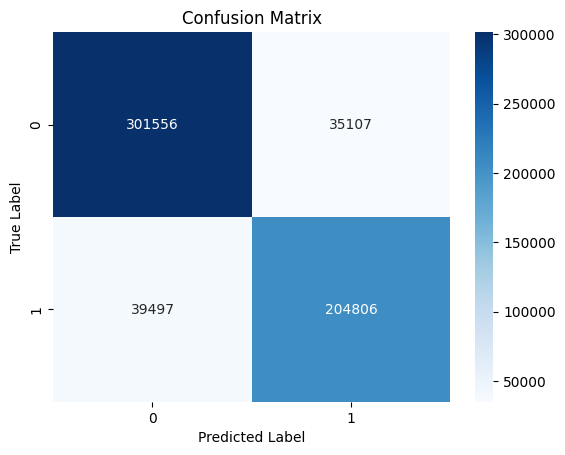


Classification report: 
              precision    recall  f1-score   support

           1       0.85      0.84      0.85    244303
           0       0.88      0.90      0.89    336663

    accuracy                           0.87    580966
   macro avg       0.87      0.87      0.87    580966
weighted avg       0.87      0.87      0.87    580966

----------------------------------------------------------------
Model: LinearSVC(class_weight='balanced', random_state=123)

Cross validated mean F1 Score = 0.885
Balanced Accuracy on Test set: 0.901
F1 Score on Test set: 0.885

Confusion Matrix:


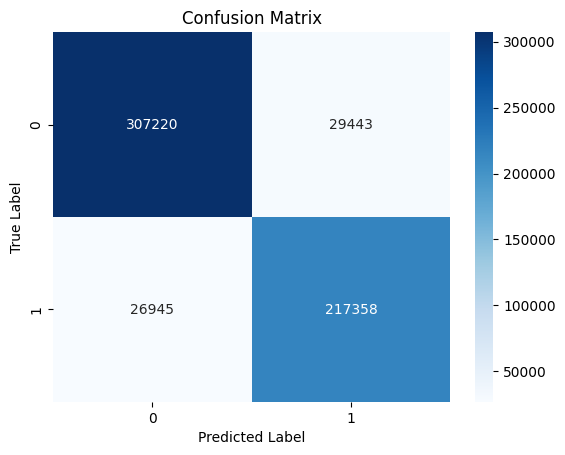


Classification report: 
              precision    recall  f1-score   support

           1       0.88      0.89      0.89    244303
           0       0.92      0.91      0.92    336663

    accuracy                           0.90    580966
   macro avg       0.90      0.90      0.90    580966
weighted avg       0.90      0.90      0.90    580966

----------------------------------------------------------------
Model: DecisionTreeClassifier(class_weight='balanced', random_state=123)

Cross validated mean F1 Score = 0.902
Balanced Accuracy on Test set: 0.917
F1 Score on Test set: 0.903

Confusion Matrix:


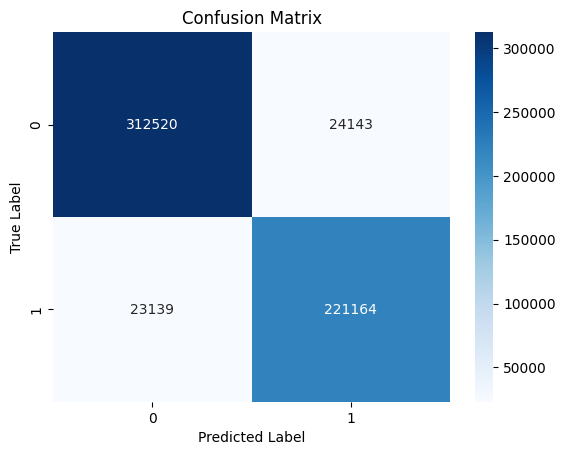


Classification report: 
              precision    recall  f1-score   support

           1       0.90      0.91      0.90    244303
           0       0.93      0.93      0.93    336663

    accuracy                           0.92    580966
   macro avg       0.92      0.92      0.92    580966
weighted avg       0.92      0.92      0.92    580966

----------------------------------------------------------------
Model: RandomForestClassifier(class_weight='balanced', random_state=123)

Cross validated mean F1 Score = 0.93
Balanced Accuracy on Test set: 0.939
F1 Score on Test set: 0.932

Confusion Matrix:


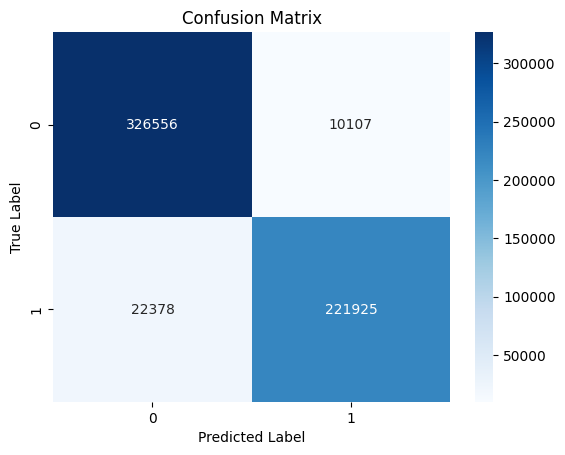


Classification report: 
              precision    recall  f1-score   support

           1       0.96      0.91      0.93    244303
           0       0.94      0.97      0.95    336663

    accuracy                           0.94    580966
   macro avg       0.95      0.94      0.94    580966
weighted avg       0.94      0.94      0.94    580966

----------------------------------------------------------------


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
trained_pipes = {}
for key, classifier in models_dict.items():
    print(f"Model: {classifier}\n")

    pipe = create_pipeline(classifier)
    # fit the pipeline on the transformed data
    pipe.fit(X_train.copy(), y_train)

    trained_pipes[key] = pipe

    # make predictions
    y_pred = pipe.predict(X_test.copy())

        # evaluate pipeline
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
    cv_scores = cross_val_score(
        pipe,
        X_train.copy(),
        y_train,
        scoring='f1',
        cv=cv,
        n_jobs=-1
    )
    print(f"Cross validated mean F1 Score = {round(np.mean(cv_scores), 3)}")

    print(f"Balanced Accuracy on Test set: {round(balanced_accuracy_score(y_test, y_pred), 3)}")
    print(f"F1 Score on Test set: {round(f1_score(y_test, y_pred), 3)}\n")

    print(f"Confusion Matrix:")
    cm = confusion_matrix(y_test, pipe.predict(X_test.copy()))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"\nClassification report: \n{classification_report(y_test, y_pred, labels=[1, 0])}")
    print("----------------------------------------------------------------")

The meaning of each of the labels is as follows:

0: a flight is not delayed

1: a flight is delayed

(Where a delay is defined as the actual departure time of a flight to be greater than 30 minutes from its scheduled departure time.)

As the class = 1 is a minority class, and is the class we are interested to predict, we observe the evaluation scores for this class in particular.

Exploring the cross validation scores among the trained classifiers, the Random Forest Classifier (RFC) has the highest score at 0.93.

Based the test dataset, the RFC also has the best performance with the highest F1 score for the positive class. It also has the highest Balanced Accuracy on the test dataset.

In [ ]:
trained_pipes

{'log_reg': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function process_features at 0x7f5954e82b90>)),
                 ('minmaxscaler', MinMaxScaler()),
                 ('logisticregression',
                  LogisticRegression(class_weight='balanced',
                                     random_state=123))]),
 'svm': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function process_features at 0x7f5954e82b90>)),
                 ('minmaxscaler', MinMaxScaler()),
                 ('linearsvc',
                  LinearSVC(class_weight='balanced', random_state=123))]),
 'dtc': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function process_features at 0x7f5954e82b90>)),
                 ('minmaxscaler', MinMaxScaler()),
                 ('decisiontreeclassifier',
                  DecisionTreeClassifier(class_weight='balanced',
                                         rando

**5. Evaluation**

**5.1 Precision-Recall Curve **

Of the Random Forest Classifier with class = 1 (flight delayed)

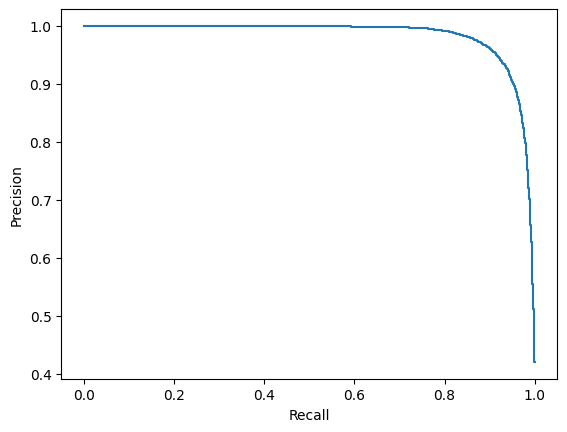

In [ ]:
predictions = trained_pipes["rfc"].predict_proba(X_test.copy())[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

**5.2 ROC Curve**

Of the Random Forest Classifier with class = 1 (flight delayed)

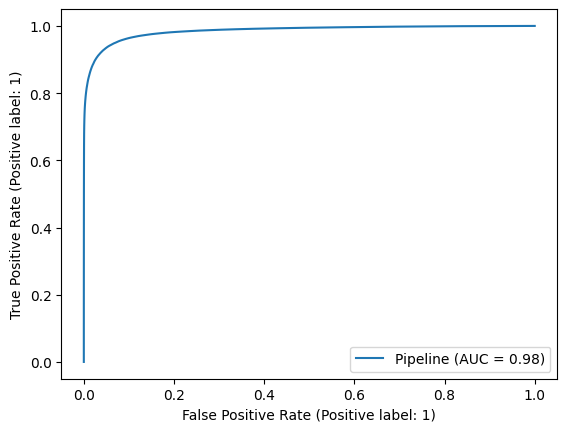

In [ ]:
RocCurveDisplay.from_estimator(trained_pipes["rfc"], X_test.copy(), y_test, pos_label=1)

In [ ]:
round(roc_auc_score(y_test, predictions), 3)

0.985

The curves above in 5.1 and 5.2 are in relation to the positive class (flight delays) of the random forest classifier. As False Negatives are highly costly in this context, we aim to increase recall. In these graphs, the Recall and TPR have the same meaning. Thus it can be viewed from the PR and ROC curves that the model performs well.